# Fitting RV Data -- adapted from exoplanet tutorial

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using exoplanet. We will follow the getting started tutorial from the excellent RadVel package where they fit for the parameters of the two planets in the K2-24 system.


Pull in data from our simulation:


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def kepler(M, e):
	"""
	Simple Kepler solver.
	Iterative solution via Newton's method. Could likely be sped up.

	Input
	-----
	M : ndarray
	e : float or ndarray of same size as M

	Returns
	-------
	E : ndarray
	"""

	M = np.array(M)
	E = M * 1.
	err = M * 0. + 1.

	while err.max() > 1e-8:
		#solve using Newton's method
		guess = E - (E - e * np.sin(E) - M) / (1. - e * np.cos(E))
		err = np.abs(guess - E)
		E = guess

	return E


def RV_model(t, period, ttran, ecosomega, esinomega, K, gamma):
	"""
	Given the orbital parameters compute the RV at times t

	Input
	-----
	t : ndarray
		Times to return the model RV.
	period : float [days]
	ttran : float [days]
	ecosomega : float
	esinomega : float 
	K : float [m/s]
	gamma : float [m/s]

	Returns
	-------
	RV_model : ndarray
		RV corresponding to the times in t [m/s].

	"""




	e = np.sqrt(ecosomega**2. + esinomega**2.)
	omega = np.arctan2(esinomega, ecosomega)

	#mean motion: n = 2pi/period
	n = 2. * np.pi / period

	# Sudarsky 2005 Eq. 9 to convert between center of transit
	# and pericenter passage (tau)
	edif = 1. - e**2.
	fcen = np.pi/2. - omega
	tau = (ttran + np.sqrt(edif) * period / (2 * np.pi) * 
		  (e * np.sin(fcen) / (1. + e * np.cos(fcen)) - 2. / np.sqrt(edif) * 
		  np.arctan(np.sqrt(edif) * np.tan(fcen / 2.) / (1. + e))))


	#Define mean anomaly: M
	M = (n * (t - tau)) % (2. * np.pi)



	#Determine the Eccentric Anomaly: E
	E = kepler(M, e)

	#Solve for fanom (measure of location on orbit)
	tanf2 = np.sqrt((1. + e) / (1. - e)) * np.tan(E / 2.)
	fanom = (np.arctan(tanf2) * 2.) % (2. * np.pi)

	#Calculate RV at given location on orbit
	RV = K * (e * np.cos(omega) + np.cos(fanom + omega)) + gamma

	return RV


def plot_RV(period, ttran, ecosomega, esinomega, K, gamma, tstart, tstop):
    '''
    Plot the RV model
    
	Input
	-----
	period : float [days]
	ttran : float [days]
	ecosomega : float
	esinomega : float 
	K : float [m/s]
	gamma : float [m/s]
	tstart : float (days)
	tstop : float (days)

	Returns
	-------
	None

    '''


    f, ax = plt.subplots(figsize=(15,10))



    t_plot = np.arange(tstart, tstop, .1)
    model = RV_model(t_plot, period, ttran, ecosomega, esinomega, K, gamma)
    ax.plot(t_plot, model, color = 'k')


   
    ax.set_xlabel("Time (TESS BJD)", fontsize = 18)
    ax.set_ylabel("Radial Velocity (m/s)", fontsize = 18)

    ax.legend(numpoints = 1, loc = 2, fontsize = 18)

    
    return ax


def plot_foldedRV(period, ttran, ecosomega, esinomega, K, gamma):
    '''
    Plot the RV model phase folded by period
    
	Input
	-----
	period : float [days]
	ttran : float [days]
	ecosomega : float
	esinomega : float 
	K : float [m/s]
	gamma : float [m/s]
	tstart : float (days)
	tstop : float (days)

	Returns
	-------
	None

    '''

    f, ax = plt.subplots(figsize=(15,10))
    
    
    tMod = np.arange(period, ttran + period)
    model = RV_model(tMod, period, ttran, ecosomega, esinomega, K, gamma)
    phase = ((tMod-ttran) % period) / period
    lsort = np.argsort(phase)
    ax.plot(phase[lsort], model[lsort], color = 'k')



    ax.set_xlabel("Phase", fontsize = 18)
    ax.set_ylabel("Radial Velocity (m/s)", fontsize = 18)
    ax.legend(numpoints = 1, loc = 2, fontsize = 18)

    
    return ax


def rvNoise(RV, stdev):
    '''
    Plot the RV model phase folded by period
    
	Input
	-----
	RV : ndarray of RV values

	Returns
	-------
	RV : ndarray of RV values with random gaussian noise added

    '''
    return RV + np.random.normal(0,stdev,len(RV))
    

## HD17289 (from Salhmann et al. 2011)

Period = 562.1+0.4−0.4 (days)

eccentricity = 0.532+0.004−0.004 

K = 1414.5+10.0−10.0  (m/s)

Time of Midtransit = 53762.5+0.9−0.9 (JD)

small omega = 52.4+0.6−0.6

inclination = 173.2+0.4−0.5 

big Omega = 2.5+3.9−3.9
 
a = 10.8+0.7 −0.7 (mas)

In [4]:
P = 562.1
e = 0.532
K = 1414.5 
T0 = 53762.5
omega = np.radians(52.4)
#Omega = np.radians(2.5)
i = np.radians(173.2)
#a_ang= 10.8


ecosw = e*np.cos(omega)
esinw = e*np.sin(omega)

time = np.linspace(T0-P, T0 + P, num=100)  # days

stdev = 100
RVs = RV_model(time, P, T0, ecosw, esinw, K, 0)
RVs_w_Noise = rvNoise(RVs, stdev)
RV_err = np.abs(np.random.normal(0,stdev,len(RVs)))

100
(100,)
100
(100,)


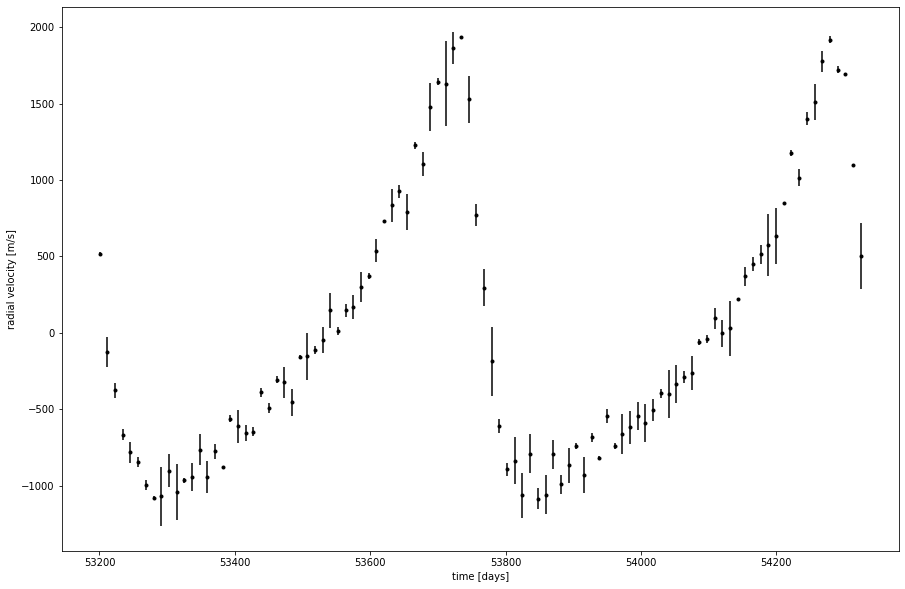

In [5]:
x = np.array(time)
print(len(x))
print(np.shape(x))
y = np.array(RVs_w_Noise)
print(len(y))
print(np.shape(y))
yerr = np.array(RV_err)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.figure(figsize = [15,10])
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

In [6]:
import exoplanet as xo

periods = P
period_errs = 0.4
t0s = T0
t0_errs = 0.9
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[896.90134011] m/s


## The radial velocity model in PyMC3¶


Now that we have the data and an estimate of the initial values for the parameters, let’s start defining the probabilistic model in PyMC3 (take a look at A quick intro to PyMC3 for exoplaneteers if you’re new to PyMC3). First, we’ll define our priors on the parameters:

In [7]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (t.min() + t.max())

In [8]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=1)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=1,
        testval=periods,
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=1, testval=np.log(Ks)[0]
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform(
        "ecc", shape=1, testval=0.1
    )
    omega = xo.distributions.Angle("omega", shape=1)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=0.1, shape=1)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 1)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, vrad + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

Now, we can plot the initial model:

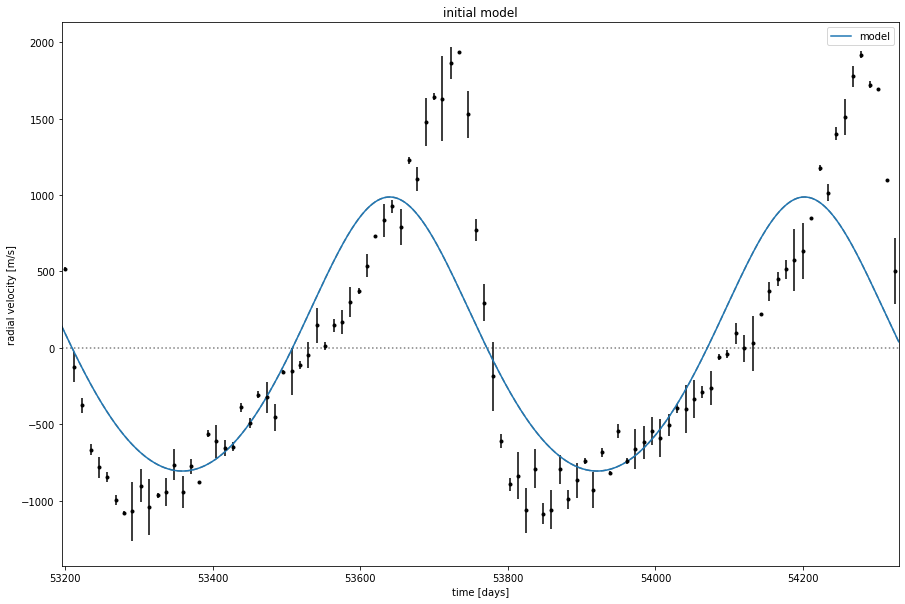

In [9]:
plt.figure(figsize=[15,10])

plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn’t look amazing so let’s fit for the maximum a posterior parameters.



In [10]:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -2158.275260339916 -> -2158.2745009286323
optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -2158.2745009286323 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


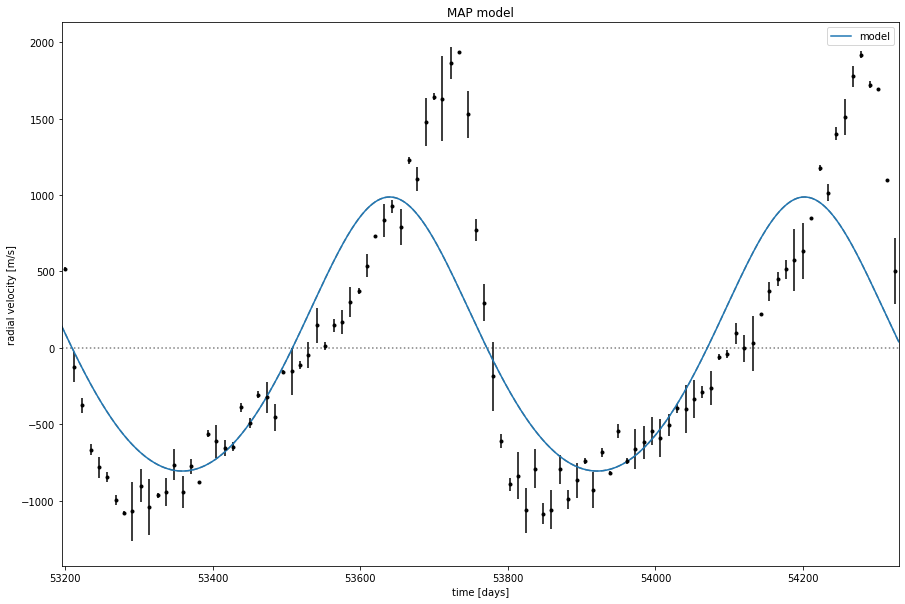

In [11]:
plt.figure(figsize=[15,10])
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

That looks better.



## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let’s start sampling. There are substantial covariances between some of the parameters so we’ll use the init="adapt_full" argument.

In [12]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        target_accept=0.95,
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.


In [13]:
pm.summary(
    trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
trend[0],0.002,0.100,-0.192,0.181,0.001,0.001,13188.0,3637.0,13171.0,6296.0,1.0
logs,4.323,0.101,4.135,4.511,0.001,0.001,11463.0,11414.0,11495.0,6376.0,1.0
omega[0],0.943,0.022,0.900,0.984,0.000,0.000,12539.0,12539.0,12594.0,5319.0,1.0
ecc[0],0.539,0.008,0.525,0.555,0.000,0.000,13961.0,13961.0,13994.0,6006.0,1.0
t0[0],53762.916,0.637,53761.727,53764.140,0.005,0.004,13811.0,13811.0,13806.0,6022.0,1.0
logK[0],7.276,0.012,7.253,7.299,0.000,0.000,13232.0,13232.0,13323.0,5872.0,1.0
P[0],561.986,0.367,561.346,562.723,0.003,0.002,14372.0,14372.0,14378.0,6327.0,1.0


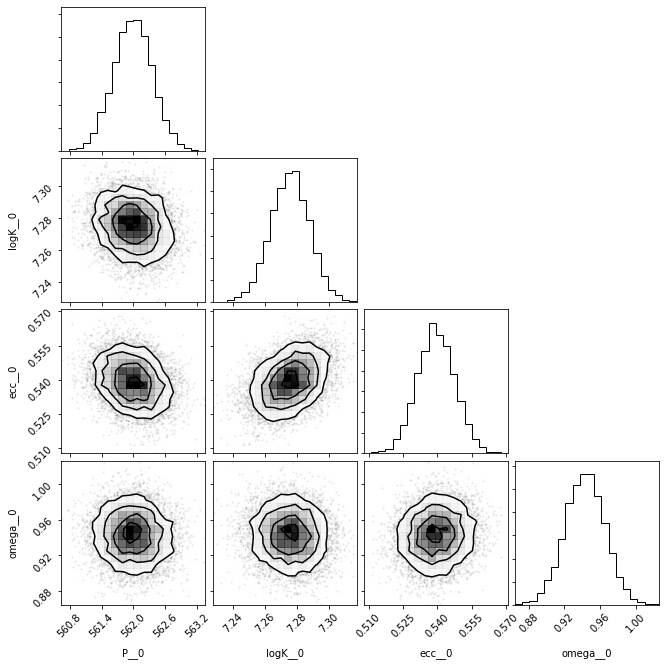

In [14]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
_ = corner.corner(samples)

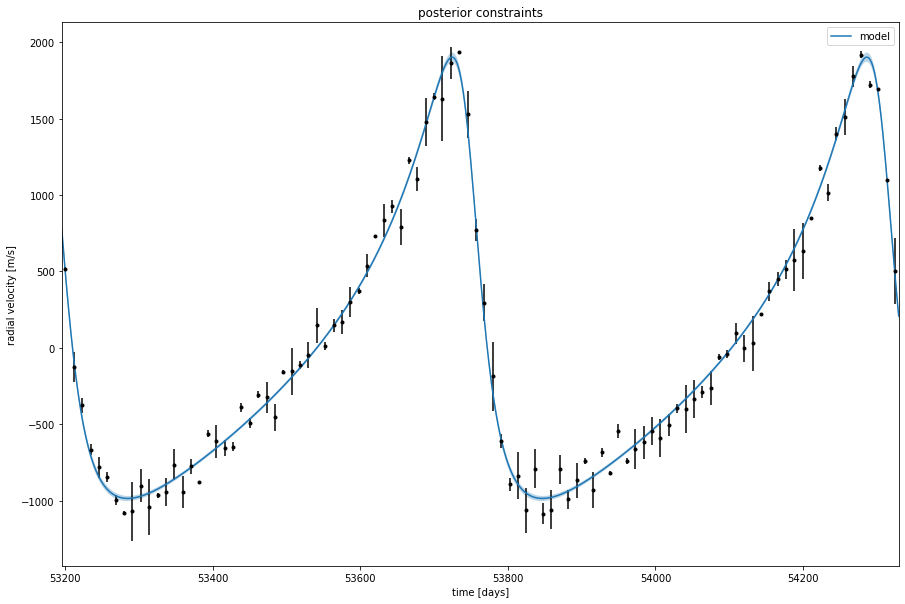

In [15]:
plt.figure(figsize = [15,10])
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

# Fitting Astrometric Data -- adapted from exoplanet tutorial

In this tutorial we’ll walk through the simplest astrometric example with exoplanet and then explain how to build up a more complicated example with parallax measurements. For our dataset, we’ll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis a_ang measured in arcseconds, since the distance to the system is assumed to be unknown. We’ll work through this example first, then introduce the extra constraints provided by parallax information.



In [381]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

print(astro_data)

   date     PA  PA_err  rho  rho_err
--------- ----- ------ ----- -------
1976.8571 139.1    0.5 0.168   0.004
1976.9226 139.6    0.3 0.171   0.001
1977.6352 134.8     --  0.15      --
1977.7335 136.5    0.4 0.147   0.009
1977.9164 130.5     -- 0.125      --
1978.6154 128.3    1.0 0.108   0.009
1979.7731 124.0     -- 0.102      --
1980.7179 106.0     -- 0.075      --
1982.7657  57.8     -- 0.061      --
 1982.852  66.7    6.5 0.091    0.01
      ...   ...    ...   ...     ...
1991.8936 157.7     -- 0.209      --
1993.8415 150.6    1.0 0.279   0.005
1993.9197 155.3     -- 0.277      --
1994.7085 154.5     -- 0.291      --
1995.9182 153.3     -- 0.296      --
 1996.694 154.3     --   0.3      --
1997.8241 153.3     -- 0.291      --
1997.8296 151.2     -- 0.298      --
1998.7773 151.0    0.5 0.285   0.002
1999.7228 149.0     -- 0.288      --
1999.7258 148.9     -- 0.282      --
Length = 35 rows


In [382]:
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians


## Astrometry Conventions

The conventions describing the orientation of the orbits are described in detail in the exoplanet paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is receeding from the observer (without radial velocity information, there is a 𝜋 degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range [0,𝜋]). The orbital inclination ranges from [0,𝜋]. 𝑖=0 describes a face-on orbit rotating counter-clockwise on the sky plane, while 𝑖=𝜋 describes a face-on orbit rotating clockwise on the sky. 𝑖=𝜋/2 is an edge-on orbit.

The observer frame 𝑋, 𝑌, 𝑍 is oriented on the sky such that +𝑍 points towards the observer, 𝑋 is the north axis, and 𝑌 is the east axis. All angles are measured in radians, and the position angle is returned in the range [−𝜋,𝜋], which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report 𝜔=𝜔secondary, whereas with an RV orbit it is generally common practice to report 𝜔=𝜔primary. The result is that unless the authors specify what they’re using, in a joint astrometric-RV orbit there is an ambiguity to which 𝜔 the authors mean, since 𝜔primary=𝜔secondary+𝜋. To standardize this across the exoplanet package, in all orbits (including astrometric-only) 𝜔=𝜔primary.

In [383]:
def positionAngle(ra1, dec1, ra2, dec2, positive=True):
    """
    Compute the position angle.
  
    The position angle is measured from the first position
    from North through East. If the `positive` flag is set
    True (default) the result will be given as an angle from
    0 to 360 degrees. If the flag is set False, the scale is
    -180 to 180 degrees with negative number increasing from
    North through West; note that this is the behavior of
    the posAng IDL routine.
    
    Parameters
    ----------
    ra1 : float
        Right ascension of first object [radians].
    dec1 : float
        Declination of first object [radians].
    ra2 : float
        Right ascension of second object [radians].
    dec2 : float
        Declination of second object [radians].
    positive : boolean, optional
        If True (default), the output will be
        given as an angle between 0 and 2pi
        degrees. Otherwise, the angle ranges
        from -pi to +pi degrees.
    
    Returns
    -------
    Position angle : float
        The position angle in radians.
    
  
    Notes
    -----
    
    .. note:: This function was adapted from PyAstronomy where
    it was imported from the IDL Astronomy User's Library.
    
    :IDL - Documentation:  
    
     NAME:
           POSANG
     PURPOSE:
           Computes rigorous position angle of source 2 relative to source 1
           
     EXPLANATION:
           Computes the rigorous position angle of source 2 (with given RA, Dec) 
           using source 1 (with given RA, Dec) as the center.
     
     CALLING SEQUENCE:
           POSANG, U, RA1, DC1, RA2, DC2, ANGLE
    
     INPUTS:
           U    -- Describes units of inputs and output:
                   0:  everything radians
                   1:  RAx in decimal hours, DCx in decimal
                           degrees, ANGLE in degrees
           RA1  -- Right ascension of point 1
           DC1  -- Declination of point 1
           RA2  -- Right ascension of point 2
           DC2  -- Declination of point 2
    
       OUTPUTS:
           ANGLE-- Angle of the great circle containing [ra2, dc2] from
                   the meridian containing [ra1, dc1], in the sense north
                   through east rotating about [ra1, dc1].  See U above 
                   for units.
    
       PROCEDURE:
           The "four-parts formula" from spherical trig (p. 12 of Smart's
           Spherical Astronomy or p. 12 of Green' Spherical Astronomy).
    
       EXAMPLE:
           For the star 56 Per, the Hipparcos catalog gives a position of 
           RA = 66.15593384, Dec = 33.94988843 for component A, and 
           RA = 66.15646079, Dec =  33.96100069 for component B.   What is the
           position angle of B relative to A?
    
           IDL> RA1 = 66.15593384/15.d   & DC1 = 33.95988843
           IDL> RA2 = 66.15646079/15.d   & DC2 = 33.96100069
           IDL> posang,1,ra1,dc1,ra2,dc2, ang
                will give the answer of ang = 21.4 degrees
       NOTES:
           (1) If RA1,DC1 are scalars, and RA2,DC2 are vectors, then ANGLE is a
           vector giving the position angle between each element of RA2,DC2 and 
           RA1,DC1.   Similarly, if RA1,DC1 are vectors, and RA2, DC2 are scalars,
           then DIS is a vector giving the position angle of each element of RA1, 
           DC1 and RA2, DC2.    If both RA1,DC1 and RA2,DC2 are vectors then ANGLE 
           is a vector giving the position angle between each element of RA1,DC1 
           and the corresponding element of RA2,DC2.    If then vectors are not the
           same length, then excess elements of the longer one will be ignored.
    
           (2) Note that POSANG is not commutative -- the position angle between
            A and B is theta, then the position angle between B and A is 180+theta 
       PROCEDURE CALLS:
            ISARRAY()
       HISTORY:
           Modified from GCIRC, R. S. Hill, RSTX, 1 Apr. 1998
           Use V6.0 notation W.L. Mar 2011
    """

    rarad1 = ra1
    rarad2 = ra2
    dcrad1 = dec1
    dcrad2 = dec2
    
    radif  = rarad2 - rarad1
    pos_angle  = np.arctan2(np.sin(radif), np.cos(dcrad1)*np.tan(dcrad2)-np.sin(dcrad1)*np.cos(radif))
    
    
    if positive and (pos_angle < 0.0):
        pos_angle += 2*np.pi

    return pos_angle  

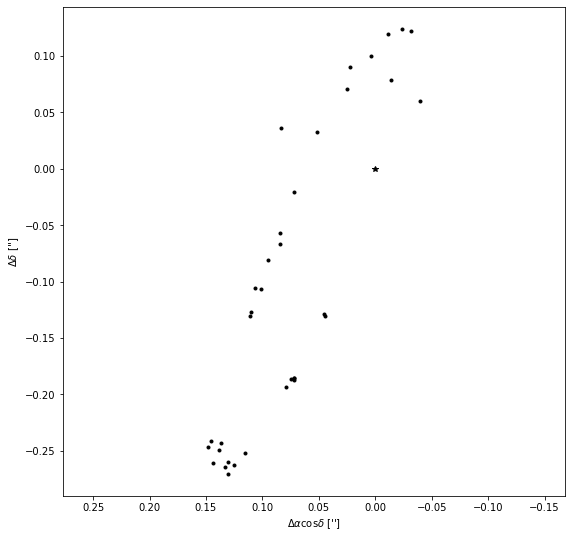

In [384]:
# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(9,9))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the “raw” measurements are the values of 𝜌 (separation) and 𝜃 (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot 𝜌 vs. time and P.A. vs. time.

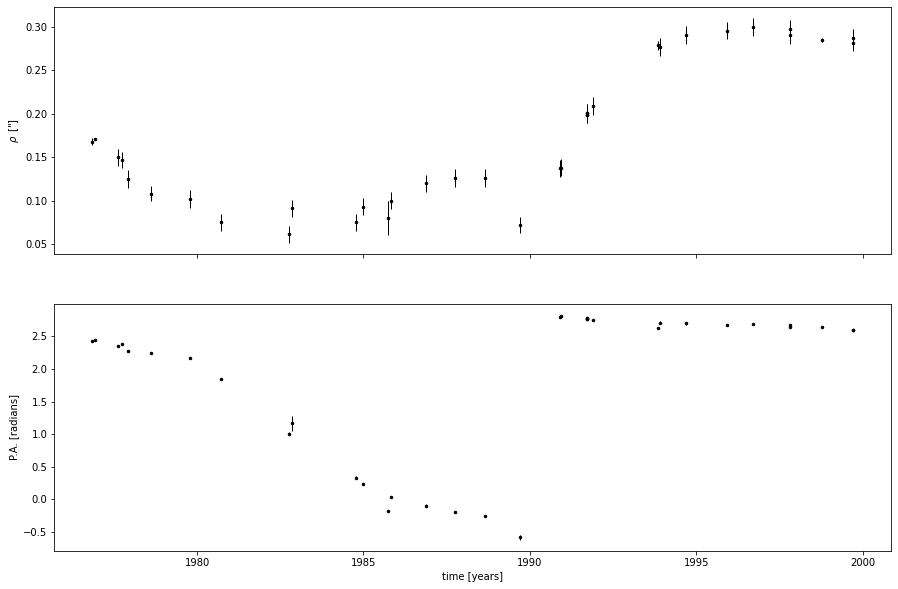

In [385]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize = [15,10])
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

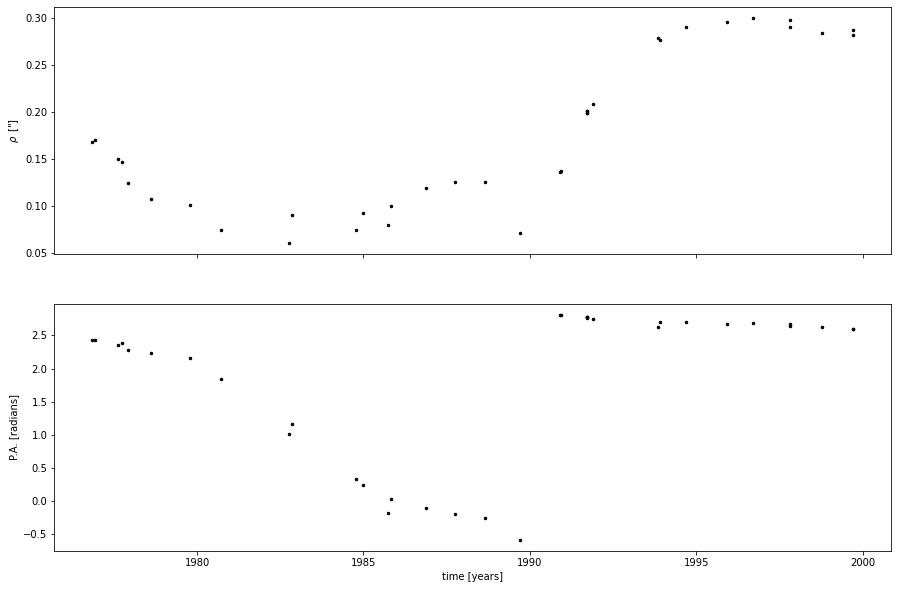

In [386]:
from PyAstronomy import pyasl

rho = np.sqrt(ys**2 + xs**2)
ra2_temp = ys /3600
dec2_temp = xs/np.cos(dec_temp) /3600

ra1_temp = np.zeros(np.shape(ra_temp))
dec1_temp = np.zeros(np.shape(dec_temp))

theta = []
for ii in range(0, len(dec_temp)):
    a_theta = positionAngle(ra1_temp[ii], dec1_temp[ii], ra2_temp[ii], dec2_temp[ii], positive=False)
    theta.append(a_theta)
    
fig, ax = plt.subplots(nrows=2, sharex=True, figsize = [15,10])
ax[0].errorbar(astro_yrs, rho, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")




In [403]:
def astrometry_model(atot, e, i, small_omega, big_omega, period, t_periapsis, t):
    """
    Given the orbital parameters compute the RA and declinatoin

    Input
    -----
    atot : float
    e : float
    i : float
    small_omega : float 
    big_omega : float 
    period: float 
    t: ndarray
        times to evaluate RA and declination

    Returns
    -------
    ra_dec : ndarray
        RA and declination corresponding to the times in t [mas].

    """
    A = atot *(np.cos(big_omega)*np.cos(small_omega) - np.sin(big_omega)*np.sin(small_omega)*np.cos(i))
    B = atot *(np.sin(big_omega)*np.cos(small_omega) + np.cos(big_omega)*np.sin(small_omega)*np.cos(i))
    F = atot *(- np.cos(big_omega)*np.sin(small_omega) - np.sin(big_omega)*np.cos(small_omega)*np.cos(i))
    G = atot *(- np.sin(big_omega)*np.sin(small_omega) + np.cos(big_omega)*np.cos(small_omega)*np.cos(i))
    
    #mean motion: n = 2pi/period
    n = 2. * np.pi / period


    #Define mean anomaly: M
    M = (n * (t - t_periapsis)) % (2. * np.pi)


    #Determine the Eccentric Anomaly: E
    E = kepler(M, e)
    
    X = np.cos(E) - e 
    Y = np.sqrt(1 - e**2)*np.sin(E)
    


    dec = A*X + F*Y
    RA = B*X + G*Y 
    

    #return np.array([dec, RA])
    return np.array([-RA, -dec])

In [404]:
def astrometryNoise(pos, stdev):
    '''
    Plot the RV model phase folded by period
    
	Input
	-----
	pos : ndarray of RA or declination values

	Returns
	-------
	pos : ndarray of RA or declination values with random gaussian noise added

    '''
    return pos + np.random.normal(0,stdev,len(pos))

In [426]:
from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

P = 562.1
e = 0.532
T0 = 53762.5
omega = np.radians(52.4)
Omega = np.radians(2.5)
i = np.radians(173.2)
a_ang= 10.8 / 1000 #mas to as
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax

t = np.linspace(T0-P, T0 + P, num=100)  # days
RA, dec = astrometry_model(a_ang, e, i, omega, Omega, P, T0, t)
RA, dec = astrometryNoise(RA, 0.001), astrometryNoise(dec, 0.001)

deg = np.pi/180
RA, dec = RA/3600 * deg, dec/3600 * deg #convert from as to radians


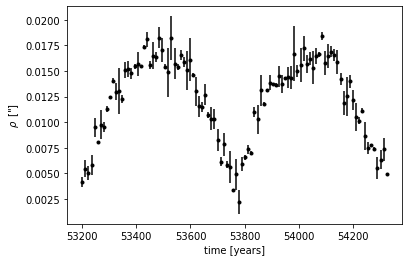

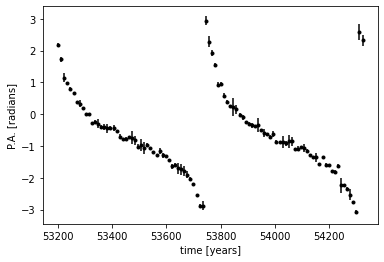

In [427]:

rho_data = np.sqrt(dec**2 + RA**2 * np.cos(dec)**2)
rho_err = np.abs(np.random.normal(0,5e-9,len(rho_data)))

ra1 = np.zeros(np.shape(RA))
dec1 = np.zeros(np.shape(dec))

ra2 = RA
dec2 = dec



theta_data = []
for ii in range(0, len(ra2)):
    a_theta = positionAngle(ra1[ii], dec1[ii], ra2[ii], dec2[ii], positive=False)
    theta_data.append(a_theta)
    
theta_err = np.abs(np.random.normal(0,0.1,len(theta_data)))


rho_data = rho_data/deg*3600 #convert radians to as
rho_err = rho_err/deg*3600 #convert radians to as

plt.errorbar(t, rho_data, yerr = rho_err, marker = '.', linestyle = '', color = 'k')
plt.ylabel(r'$\rho\,$ ["]')
plt.xlabel("time [years]")
plt.show()


plt.errorbar(t, theta_data, yerr = theta_err, marker = '.', linestyle = '', color = 'k')
plt.ylabel(r"P.A. [radians]")
plt.xlabel("time [years]")
plt.show()



## Fitting the astrometric orbit with exoplanet

To get started, let’s import the relative packages from exoplanet, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

.. note:: Orbits in *exoplanet* generally specify the semi-major axis in units of solar radii `R_sun`. For transits and RV orbits, you usually have enough external information (e.g., estimate of stellar mass from spectral type) to put a physical scale onto the orbit. For the most basic of astrometric orbits without parallax information, however, this information can be lacking and thus it makes sense to fit for the semi-major axis in units of `arcseconds`. But, `exoplanet` is modeling a real orbit (where semi-major axis is in units of `R_sun`), so we do need to at least provide a fake parallax to convert from arcseconds to `R_sun.`

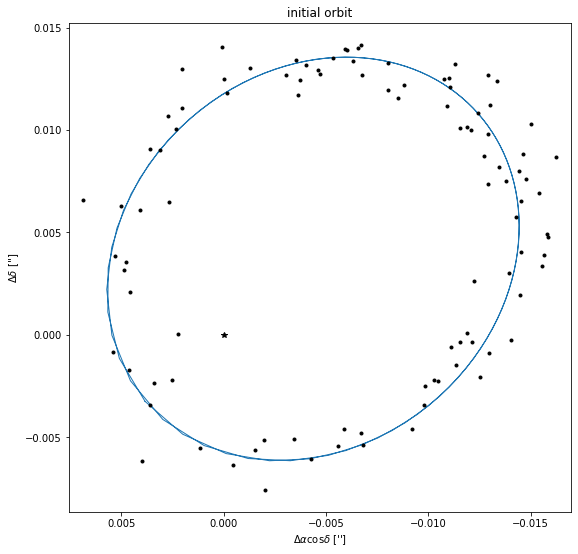

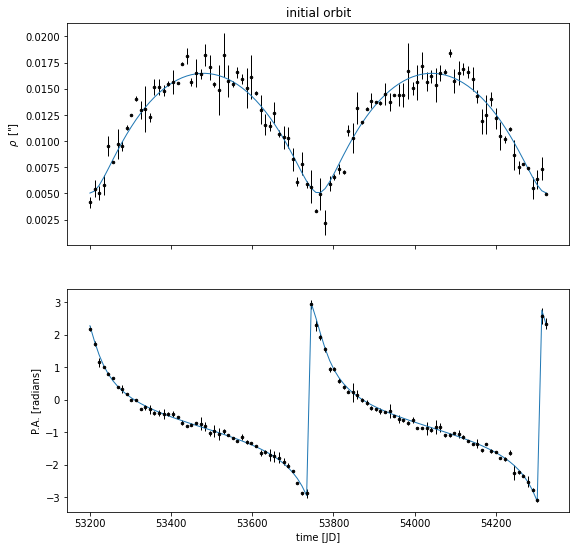

In [428]:
import theano

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(9, 9))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
ax.plot(RA*3600/ deg, dec*3600/ deg, ".k")


ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(9, 9))
ax[0].errorbar(t, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(t, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.



In [448]:
from exoplanet.distributions import Angle
yr = 365.25

# for predicted orbits
t_fine = np.linspace(t.min() - 500, t.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)
        
        
        a_ang = pm.Uniform("a_ang", 0.005, .05, testval=10.8 / 1000)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 2 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(2.5 * yr), sd=1.0, testval=np.log(2 * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = np.radians(52.4)
        Omega0 = np.radians(2.5)
        #p = Angle("p", testval=0.5 * (Omega0 + omega0))
        #m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega_mod = pm.Uniform("omega", lower = 0, upper = np.pi, testval = omega0)
        Omega_mod = pm.Uniform("Omega", lower = 0, upper = np.pi, testval = Omega0)
        #omega = pm.Deterministic("omega", p - m)
        #Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(np.radians(173.2))
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.532)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(t, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=0.05
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        #print(len(rho_model), len(rho_tot_err), len(rho_data))
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[omega_mod, Omega_mod, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()


optimizing logp for variables: [log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: -2074.365299963966 -> 119.7991070100889
optimizing logp for variables: [phase]


message: Optimization terminated successfully.
logp: 119.7991070100889 -> 140.35508068796983
optimizing logp for variables: [ecc, Omega, omega]


message: Optimization terminated successfully.
logp: 140.35508068796983 -> 176.58165368093347
optimizing logp for variables: [phase, a_ang, logP]


message: Optimization terminated successfully.
logp: 176.58165368093347 -> 361.75283392639506
optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang]


message: Optimization terminated successfully.
logp: 361.75283392639506 -> 643.854820697971


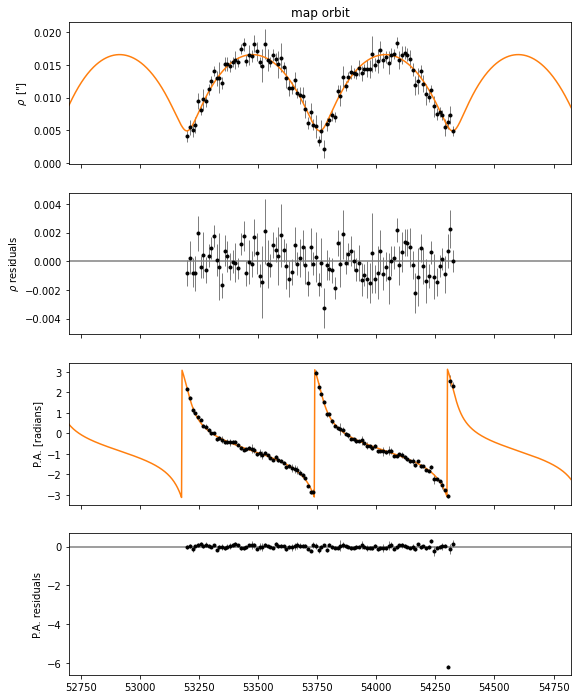

In [449]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(9, 12))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(t, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    t, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(t, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    t, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

Now let’s sample the posterior.



In [450]:
np.random.seed(1234)
with model:
    trace = pm.sample(
        tune=5000,
        draws=4000,
        start=map_soln,
        cores=2,
        chains=2,
        init="adapt_full",
        target_accept=0.9,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang]


Sampling 2 chains for 5_000 tune and 4_000 draw iterations (10_000 + 8_000 draws total) took 55 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


First we can check the convergence for some of the key parameters.



In [451]:
with model:
    summary = pm.summary(
        trace,
        varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"],
    )
summary

/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,562.159,1.044,560.269,564.181,0.011,0.008,9083.0,9083.0,9074.0,5848.0,1.0
tperi,53760.529,0.650,53759.316,53761.756,0.007,0.005,9073.0,9073.0,9058.0,5661.0,1.0
a_ang,0.011,0.000,0.011,0.011,0.000,0.000,7782.0,7724.0,8188.0,3733.0,1.0
omega,1.573,0.902,0.075,3.017,0.009,0.007,10724.0,9276.0,9317.0,4739.0,1.0
Omega,1.554,0.903,0.058,2.996,0.009,0.007,10096.0,8409.0,9045.0,4801.0,1.0
incl,3.003,0.063,2.887,3.117,0.001,0.001,4376.0,4327.0,3886.0,2673.0,1.0
ecc,0.541,0.006,0.530,0.554,0.000,0.000,8926.0,8924.0,8925.0,5508.0,1.0


Now make a corner plot

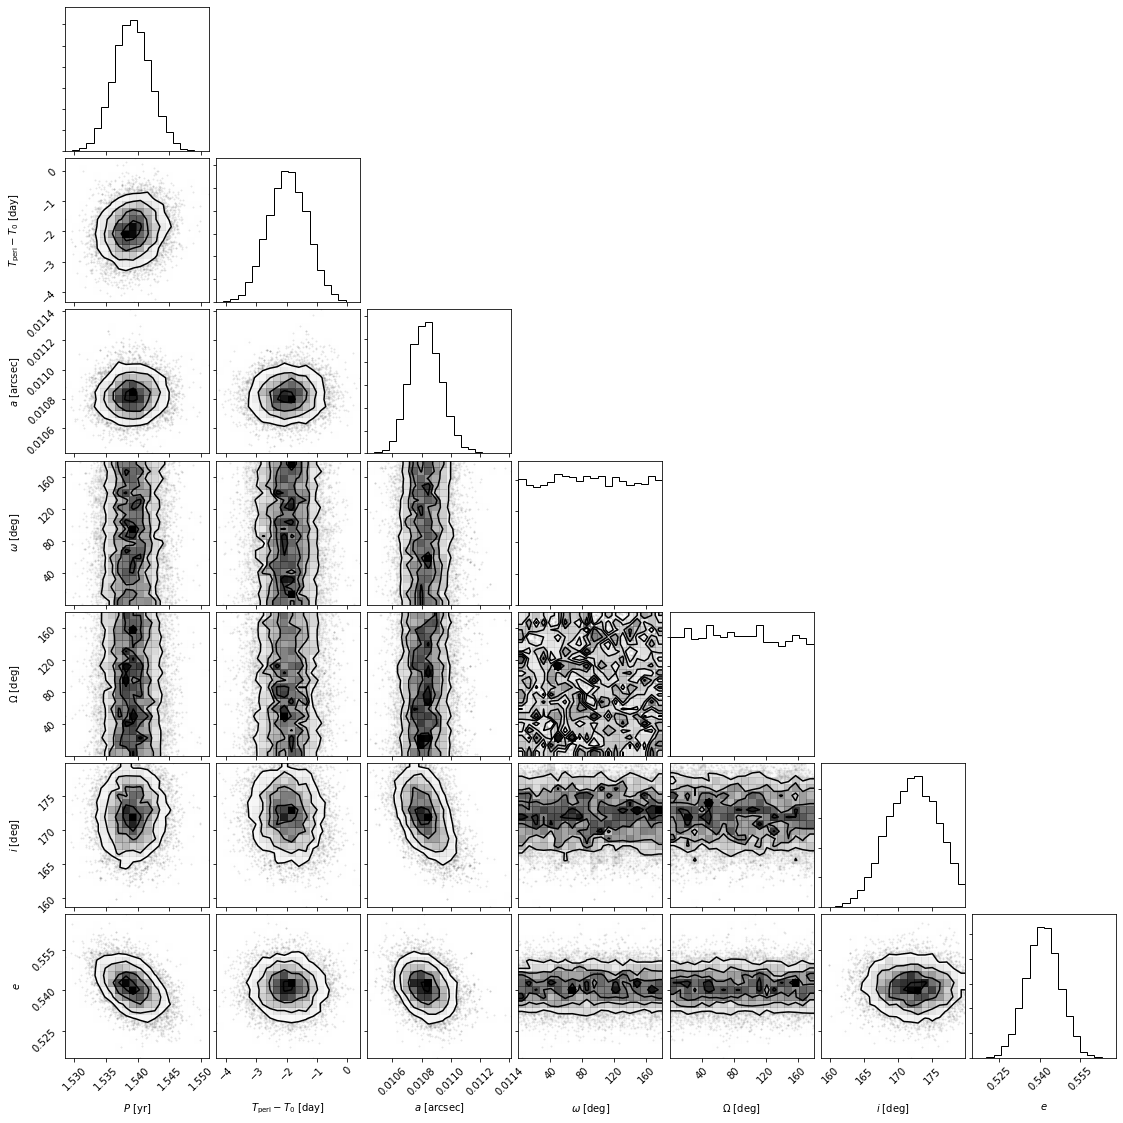

In [452]:
samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

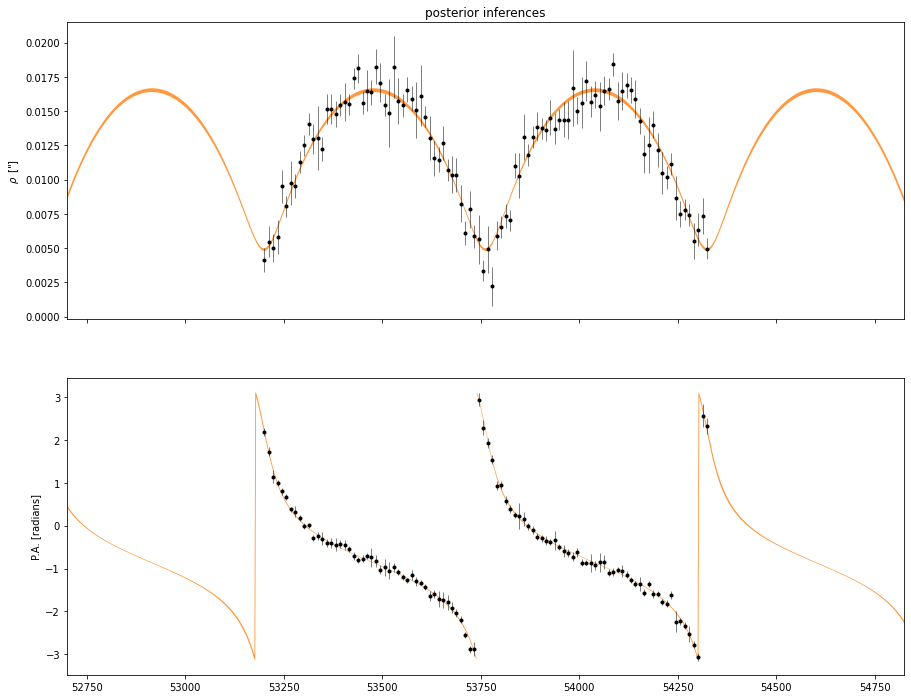

In [453]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15, 12))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err ** 2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0))
)
tot_theta_err = np.sqrt(
    theta_err ** 2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0))
)

ax[0].errorbar(t, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(t, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry. 

## Including parallax
While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just 𝜌 and 𝜃 isn’t actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us (𝑖, 𝜔, and Ω). The only truly intrinsic parameters are 𝑃 and 𝑒. To learn more about some of the physical parameters, such as the total mass of the system, we’d like to incorporate distance information to put a physical scale to the problem.

The Hipparcos parallax is 𝜛=20.8 ± 1.2 mas.

We can use exactly the same model as above with only an added parallax constraint:



In [454]:
plx_model, plx_map_soln = get_model(parallax=[20.8, 1.2])


optimizing logp for variables: [log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: -2072.664800954425 -> 121.49960601962985
optimizing logp for variables: [phase]


message: Optimization terminated successfully.
logp: 121.49960601962985 -> 142.05557969751078
optimizing logp for variables: [ecc, Omega, omega]


message: Optimization terminated successfully.
logp: 142.05557969751078 -> 178.28215269047436
optimizing logp for variables: [phase, a_ang, logP]


message: Optimization terminated successfully.
logp: 178.28215269047436 -> 363.4533329359361
optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


message: Optimization terminated successfully.
logp: 363.4533329359361 -> 645.5562213637573


In [455]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(
        tune=5000,
        draws=4000,
        start=plx_map_soln,
        cores=2,
        chains=2,
        init="adapt_full",
        target_accept=0.9,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, Omega, omega, logP, a_ang, m_plx]


Sampling 2 chains for 5_000 tune and 4_000 draw iterations (10_000 + 8_000 draws total) took 54 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Check the convergence diagnostics.



In [456]:
with model:
    summary = pm.summary(
        plx_trace,
        varnames=[
            "P",
            "tperi",
            "a_ang",
            "omega",
            "Omega",
            "incl",
            "ecc",
            "M_tot",
            "plx",
        ],
    )
summary

/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,562.126,1.045,560.172,564.079,0.010,0.007,9952.0,9951.0,9955.0,5459.0,1.0
tperi,53760.547,0.659,53759.371,53761.823,0.007,0.005,9819.0,9819.0,9834.0,5788.0,1.0
a_ang,0.011,0.000,0.011,0.011,0.000,0.000,7821.0,7789.0,7944.0,5048.0,1.0
omega,1.557,0.906,0.032,2.973,0.009,0.007,9355.0,8431.0,8791.0,4554.0,1.0
Omega,1.587,0.899,0.138,3.071,0.009,0.007,10683.0,9234.0,9302.0,4771.0,1.0
incl,3.003,0.063,2.895,3.121,0.001,0.001,5590.0,5526.0,5129.0,3847.0,1.0
ecc,0.541,0.006,0.530,0.553,0.000,0.000,8844.0,8844.0,8835.0,5221.0,1.0
M_tot,0.061,0.011,0.042,0.083,0.000,0.000,8510.0,7811.0,9120.0,5400.0,1.0
plx,0.021,0.001,0.018,0.023,0.000,0.000,9151.0,9151.0,9146.0,5560.0,1.0


Make corner plot for physical parameters

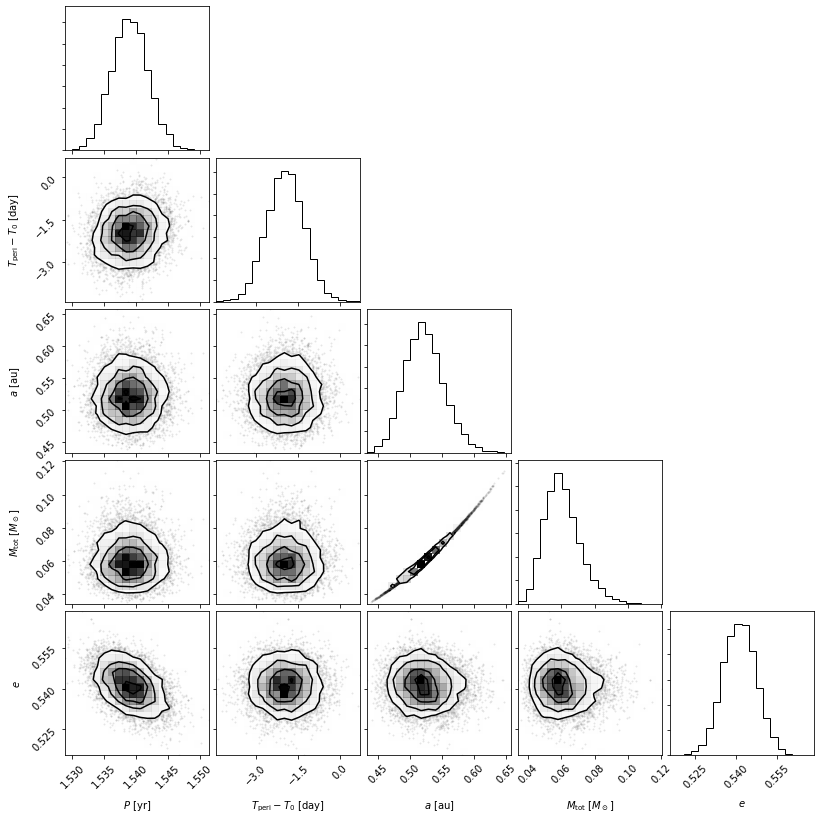

In [457]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

In [400]:
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  #  reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days
T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]


t = np.linspace(T0-P, T0 + P, num=100)  # days
RA, dec = astrometry_model(a_ang, e, i, omega, Omega, P, T0, t)
RA, dec = astrometryNoise(RA, 0.001), astrometryNoise(dec, 0.001)

deg = np.pi/180
RA, dec = RA/3600 * deg, dec/3600 * deg #convert from as to radians

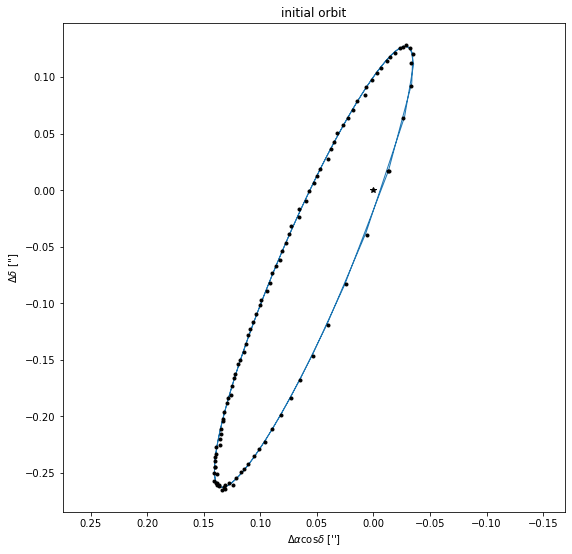

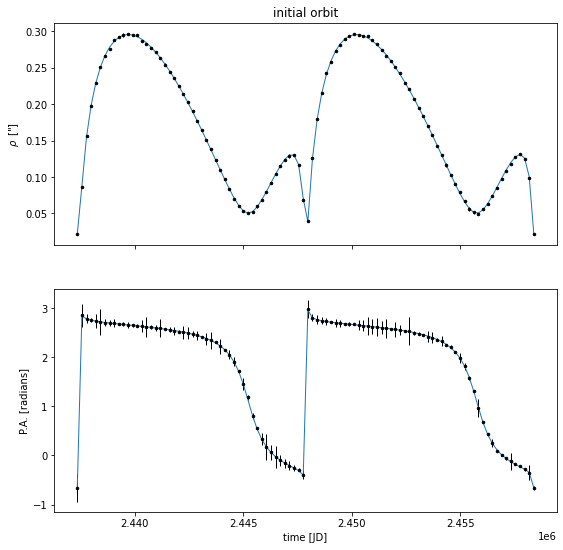

In [402]:

rho_data = np.sqrt(dec**2 + RA**2 * np.cos(dec)**2)
rho_err = np.abs(np.random.normal(0,5e-9,len(rho_data)))

ra1 = np.zeros(np.shape(RA))
dec1 = np.zeros(np.shape(dec))

ra2 = RA
dec2 = dec



theta_data = []
for ii in range(0, len(ra2)):
    a_theta = positionAngle(ra1[ii], dec1[ii], ra2[ii], dec2[ii], positive=False)
    theta_data.append(a_theta)
    
theta_err = np.abs(np.random.normal(0,0.1,len(theta_data)))


rho_data = rho_data/deg*3600 #convert radians to as
rho_err = rho_err/deg*3600 #convert radians to as

import theano

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(9, 9))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
ax.plot(RA*3600/ deg, dec*3600/ deg, ".k")


ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(9, 9))
ax[0].errorbar(t, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(t, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")